# Tasks
## Understanding the problem
### Description
**Cliff Walking** is a *single-agent*, *deterministic*, and *discrete* reinforcement learning problem.
- Single agent means that there is only one agent. *aka not multi-agent*.
- Deterministic means that given an action-state pair `(s, a)`, the transition function will always yield state `s'`. *aka not stochastic*.
- Discrete means that there is a countable amount of actions and observations. *aka not continuous*.

The *goal of the agent* is to go from the starting position to the target position without falling off the cliff.

The *action space* is of shape (4,). The agent is equipped with 4 directional movements to navigate the environment.

The *observation space* is of shape (48,). An observation represents the position of the agent on the map. There are 37 allowed states, and 9 states the agent must avoid.

The *reward* is: -1 for each step the agent takes, and -100 for falling off the cliff. No reward is necessary for reaching the goal as the target position represents the *terminal state*, meaning that for the agent to maximize its reward, it is implied that it must reach the target position.

### Optimal policy
The optimal policy to solve this problem would be to move right alongside the cliff and reach the finish point without going north, minimizing the travel cost.

### Highest/Lowest reward achievable
The **highest** reward achievable is -13, as the agent needs a minimum of 13 steps to reach the terminal state.

*For the pre-configured parameters of this assignment*, the **lowest** reward achievable is -1099, as the agent can travel for 999 steps, and on their final 1000th step they can walk off the cliff for -100 reward.

## Baseline strategy: Equiprobable Random Policy

### Implement a new ERP Agent

In [21]:
import gymnasium as gym
import matplotlib.pyplot as plt
import time
import random
import pygame
import numpy as np
from typing_extensions import override

In [22]:
env = gym.make('CliffWalking-v0')

In [23]:
class ERPAgent():
    def __init__(self):
        self.episode_reward = 0
        
    def get_action(self):
        return env.action_space.sample()
        
    def reset(self):
        self.episode_reward = 0

### Evaluate ERP Agent
The random policy is not effective. The agent **practically never reaches the goal once in 500 episodes**. Average reward across 500 episodes is printed below. Optimal reward is never reached.

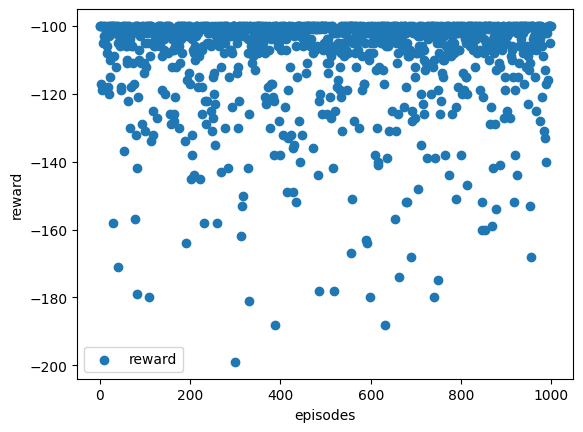

Stats in 1000 episodes:
 > Average reward: -109.603
 > Total wins: 0


In [24]:
wins = 0
max_episodes = 1000
max_steps = 100
global_rewards = []
agent = ERPAgent()

for episode in range(max_episodes):
    state, _ = env.reset()
    agent.reset()
    done = False
    for step in range(max_steps):
        action = agent.get_action()
        new_state, reward, done, _, _ = env.step(action)
        
        agent.episode_reward += reward

        if done:
            wins+=1
        elif reward == -100: #fallen off
            break

        state = new_state

    global_rewards.append(agent.episode_reward)

env.close()

plt.scatter(x=range(max_episodes), y=global_rewards, label='reward')
plt.xlabel('episodes')
plt.ylabel('reward')
plt.legend()
plt.show()

print(f"Stats in {max_episodes} episodes:")
print(" > Average reward:", sum(global_rewards)/len(global_rewards))
print(" > Total wins:", wins)

## Q-Learning
### Implement Q-Learning agent


In [25]:
class QAgent():
    def __init__(self, learning_rate=0.1, gamma=0.99, epsilon=0.99, min_epsilon=0.01, epsilon_decay_rate=0.001):
        self.episode_reward = 0
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.learning_rate = learning_rate
        self.gamma = gamma # discount rate
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        
    def get_action(self, state):
        if random.random() > self.epsilon: #exploitation vs exploration balance
            action = np.argmax(self.q_table[state])
        else:
            action = env.action_space.sample()
        return action
        
    def update(self, old_state, action, reward, new_state):
        self.q_table[state, action] = self.q_table[state, action]*(1 - self.learning_rate) + self.learning_rate*(reward + self.gamma*np.max(self.q_table[new_state, :]))
    
    def epsilon_decay(self):
        self.epsilon = max(self.min_epsilon, self.epsilon-self.epsilon_decay_rate)

    def reset(self):
        self.episode_reward = 0


### Evaluate Q-Learning agent
#### 1 Experiment

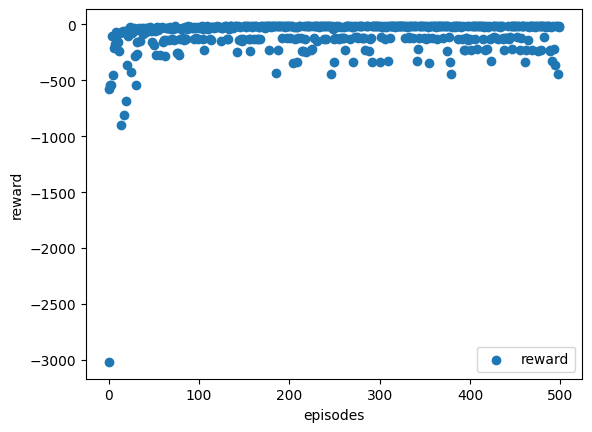

Stats in 500 episodes:
 > Average reward: -90.67
 > Best reward -13
 > Total wins: 500


In [26]:
max_episodes = 500
max_steps = 1000
agent = QAgent(learning_rate=0.15, gamma=0.9, epsilon=0.15, epsilon_decay_rate=0) # configure hyperparameters in init()
wins = 0
global_rewards = []
for episode in range(max_episodes):
	state, _ = env.reset()
	agent.reset()
	done = False
	for step in range(max_steps):
		action = agent.get_action(state)
		new_state, reward, done, _, _ = env.step(action)
		agent.update(state, action, reward, new_state)

		state = new_state
		agent.episode_reward += reward
		if done:
			wins+=1
			break

	agent.epsilon_decay()
	global_rewards.append(agent.episode_reward)
env.close()

plt.scatter(x=range(max_episodes), y=global_rewards, label='reward')
plt.xlabel('episodes')
plt.ylabel('reward')
plt.legend()
plt.show()

print(f"Stats in {max_episodes} episodes:")
print(" > Average reward:", sum(global_rewards)/len(global_rewards))
print(" > Best reward", max(global_rewards))
print(" > Total wins:", wins)

#### 100 Experiments
* The Q-Table is not reset between experiments. We thought the point of multiple experiments was to analyze performance between different levels of training.

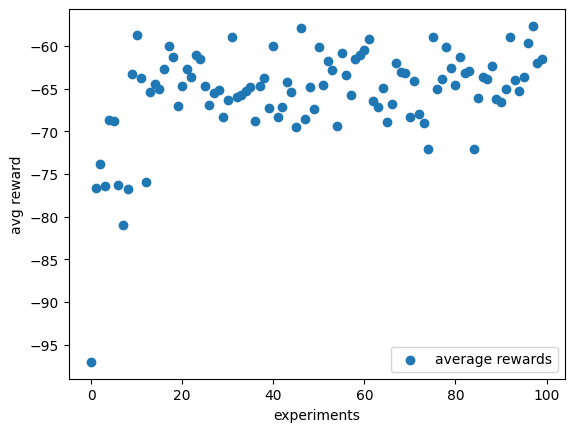

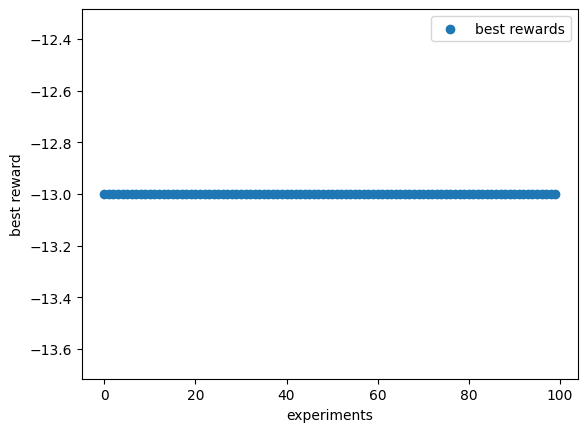

Stats in 100 experiments:
 > Total wins: 49999


In [27]:
max_experiments = 100
experiment_rewards_avg = []
experiment_rewards_best = []
wins = 0
agent = QAgent(learning_rate=0.15, gamma=0.9, epsilon=0.15, epsilon_decay_rate=0) # configure hyperparameters in init()
for experiment in range(max_experiments):
    max_episodes = 500
    max_steps = 1000
    global_rewards = []
    for episode in range(max_episodes):
        state, _ = env.reset()
        agent.reset()
        done = False
        for step in range(max_steps):
            action = agent.get_action(state)
            new_state, reward, done, _, _ = env.step(action)
            agent.update(state, action, reward, new_state)

            state = new_state
            agent.episode_reward += reward
            if done:
                wins+=1
                break

        agent.epsilon_decay()
        global_rewards.append(agent.episode_reward)
    experiment_rewards_avg.append(sum(global_rewards)/len(global_rewards))
    experiment_rewards_best.append(max(global_rewards))
env.close()

plt.scatter(x=range(max_experiments), y=experiment_rewards_avg, label='average rewards')
plt.xlabel('experiments')
plt.ylabel('avg reward')
plt.legend()
plt.show()

plt.scatter(x=range(max_experiments), y=experiment_rewards_best, label='best rewards')
plt.xlabel('experiments')
plt.ylabel('best reward')
plt.legend()
plt.show()

print(f"Stats in {max_experiments} experiments:")
print(" > Total wins:", wins)

## Improving Q-Learning
**Optimizing epsilon**: an `epsilon decay rate` has been implemented. This ensures a smooth transition from exploration to exploitation probability. A final, definite, optimal epsilon value will not be presented.

**Optimizing gamma**: iterative trial and error

Unlike last time, the agent (Q-Table) is reset between experiments, as the dependent variable now is not training amount, but the gamma value.

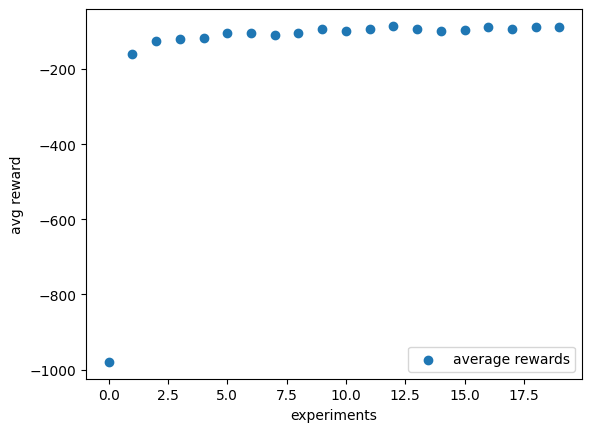

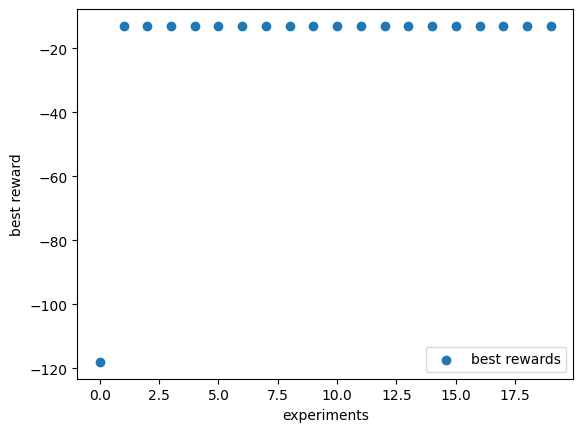

Stats in 20 experiments:
 > Total wins: 9605
Max avg reward found with gamma: 0.6


In [37]:
max_experiments = 20
experiment_rewards_avg = []
experiment_rewards_best = []
gammas = np.arange(0.0, 100.0, 0.05)
wins = 0
for experiment in range(max_experiments):
    agent = QAgent(learning_rate=0.15, gamma=gammas[experiment], epsilon=0.15, epsilon_decay_rate=0) # configure hyperparameters in init()
    max_episodes = 500
    max_steps = 1000
    global_rewards = []
    for episode in range(max_episodes):
        state, _ = env.reset()
        agent.reset()
        done = False
        for step in range(max_steps):
            action = agent.get_action(state)
            new_state, reward, done, _, _ = env.step(action)
            agent.update(state, action, reward, new_state)

            state = new_state
            agent.episode_reward += reward
            if done:
                wins+=1
                break

        agent.epsilon_decay()
        global_rewards.append(agent.episode_reward)
    experiment_rewards_avg.append(sum(global_rewards)/len(global_rewards))
    experiment_rewards_best.append(max(global_rewards))
env.close()

plt.scatter(x=range(max_experiments), y=experiment_rewards_avg, label='average rewards')
plt.xlabel('experiments')
plt.ylabel('avg reward')
plt.legend()
plt.show()

plt.scatter(x=range(max_experiments), y=experiment_rewards_best, label='best rewards')
plt.xlabel('experiments')
plt.ylabel('best reward')
plt.legend()
plt.show()

print(f"Stats in {max_experiments} experiments:")
print(" > Total wins:", wins)
print(f"Max avg reward found with gamma:", experiment_rewards_avg.index(max(experiment_rewards_avg))/20)

We see that:
- when `gamma == 0` agent is unable to find the optimal solution, and does not perform well
- higher gamma values yield better average reward return